## Main Program for classification

# imports

In [16]:
# imports

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from shapely.geometry import Polygon, box
from shapely.affinity import scale, affine_transform
from collections import Counter

# functions for feature exctraction

[[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


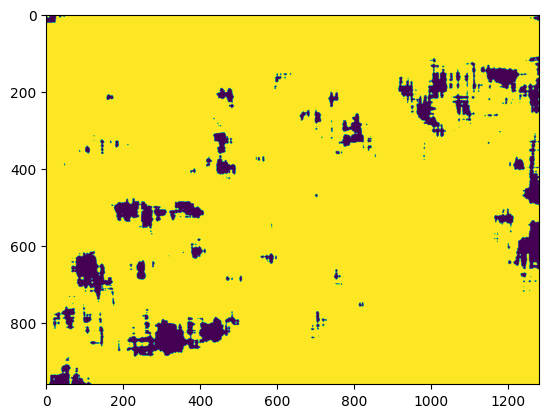

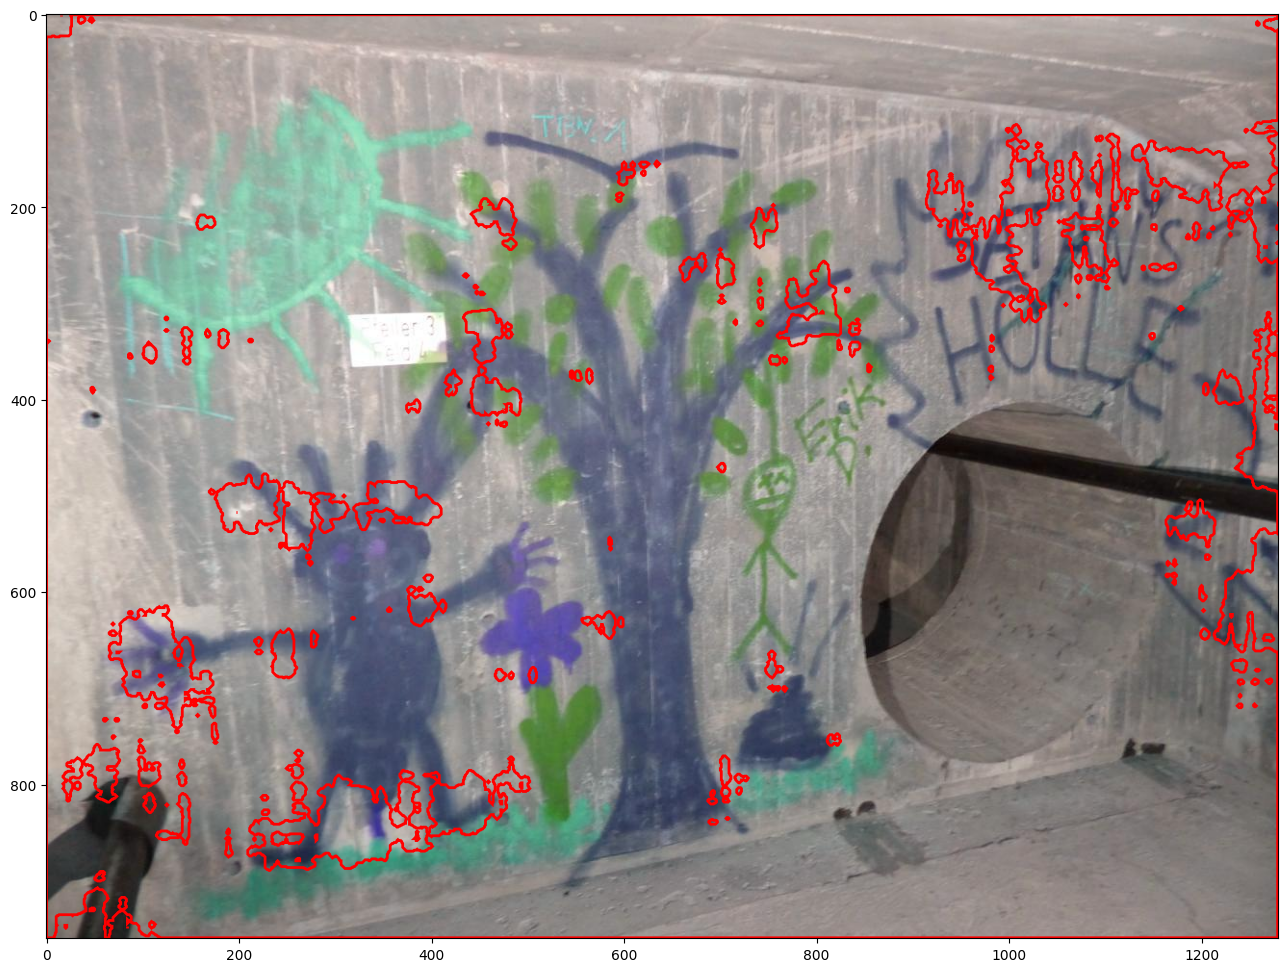

286


In [27]:
# obsolete function to find rough textures in an image
def find_rough_areas(image, threshold=8):

    #read in image as greyscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #apply local binary pattern
    lbp = local_binary_pattern(image, P=8, R=2, method='uniform')

    lbp_uint8 = np.uint8((lbp / lbp.max())*255)
    
    blurred = cv2.blur(lbp_uint8, (5, 5), 0)
    mean = np.mean(blurred)
    std = np.std(blurred)
    median = np.median(blurred)
    #apply thresholding
    _, binary_image = cv2.threshold(blurred, mean - std, 255, cv2.THRESH_BINARY) 

    binary_blurred = cv2.blur(binary_image, (50, 50), 0)
    mean = np.mean(binary_blurred)
    std = np.std(binary_blurred)
    #apply thresholding
    _, binary_image = cv2.threshold(binary_blurred, mean - 1.5 * std, 255, cv2.THRESH_BINARY) # normlaize and convert to uint8, then blur
    plt.imshow(binary_image)
    print(binary_image)
    np.histogram(binary_image, bins=10, range=None, density=None, weights=None)
    
    #plt.imshow(binary_image)
    
    # Uncomment and adjust the contour finding and polygon processing as needed
    
    contours_outer, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #contours_tree, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    #contours_ccomp, _ = cv2.findContours(binary_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    polygons = []
    for contour in contours[0:-1]:
        points = []
        for point in contour:
            points.append(*point.tolist())
        polygons.append(points)

    return lbp, polygons

image_path = f"data/dacl10k_v2_devphase/images/train/dacl10k_v2_train_0001.jpg"
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
dark_areas, dark_polygons = find_rough_areas(image)
plot_picture_with_polygons(image, dark_polygons)
print(len(dark_polygons))

In [1]:
#function to find rough areas in picture
def rough_image_filter(image, threshold=8):

    #read in image as greyscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #apply local binary pattern
    lbp = local_binary_pattern(image, P=8, R=2, method='uniform')

    lbp_uint8 = np.uint8((lbp / lbp.max())*255)
    
    blurred = cv2.blur(lbp_uint8, (5, 5), 0)
    mean = np.mean(blurred)
    std = np.std(blurred)
    median = np.median(blurred)
    #apply thresholding
    _, binary_image = cv2.threshold(blurred, mean - std, 255, cv2.THRESH_BINARY) 

    binary_blurred = cv2.blur(binary_image, (50, 50), 0)
    mean = np.mean(binary_blurred)
    std = np.std(binary_blurred)
    #apply thresholding
    _, binary_image = cv2.threshold(binary_blurred, mean - 1.5 * std, 255, cv2.THRESH_BINARY) # normlaize and convert to uint8, then blur

    return binary_image

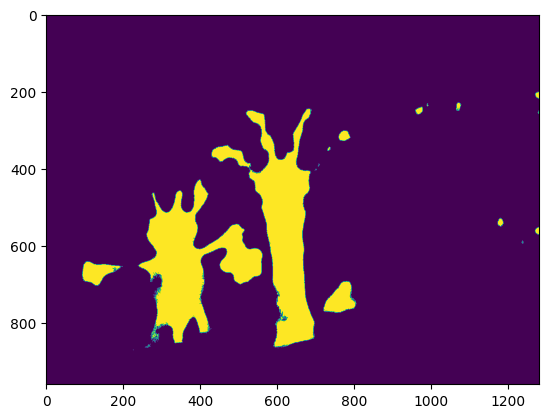

In [34]:
# obsolete function to find reddish areas in an image
def find_reddish_areas(image):

    def color_detector(image, lower_bounds: list, upper_bounds: list) -> list:
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        mask = np.zeros(hsv_image.shape[:2], dtype=np.uint8)
        for lower_bound, upper_bound in zip(lower_bounds, upper_bounds):
            lower_bound = np.array(lower_bound)
            upper_bound = np.array(upper_bound)
            mask += cv2.inRange(hsv_image, lower_bound, upper_bound)
        return mask

    rusty_lower_bounds = [[0, 40, 50], [170, 40, 50]]
    rusty_upper_bounds = [[10, 255, 200], [180, 255, 200]]
    blurred = cv2.blur(image, (30, 30), 0)
    reddish_areas = color_detector(blurred, rusty_lower_bounds, rusty_upper_bounds)
    plt.imshow(reddish_areas)
    contours, _ = cv2.findContours(reddish_areas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        points = []
        for point in contour:
            points.append(*point.tolist())
        polygons.append(points)

    return image, polygons


#function to find reddish areas in an image
def find_reddish_areas2(image):

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    rusty_lower_bounds = [[0, 40, 50], [170, 40, 50]]
    rusty_upper_bounds = [[10, 255, 200], [180, 255, 200]]
    mask = cv2.inRange(hsv, rusty_lower_bounds, rusty_upper_bounds)
    




In [2]:
#function to identify reddisch areas in an image
def reddish_image_filter(image):

    def color_detector(image, lower_bounds: list, upper_bounds: list) -> list:
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        mask = np.zeros(hsv_image.shape[:2], dtype=np.uint8)
        for lower_bound, upper_bound in zip(lower_bounds, upper_bounds):
            lower_bound = np.array(lower_bound)
            upper_bound = np.array(upper_bound)
            mask += cv2.inRange(hsv_image, lower_bound, upper_bound)
        return mask

    rusty_lower_bounds = [[0, 40, 50]]
    rusty_upper_bounds = [[20, 255, 200]]
    reddish_areas = color_detector(image, rusty_lower_bounds, rusty_upper_bounds)

    return reddish_areas

In [4]:
#find darker areas in an image
def find_darker_areas(image, threshold=100):
    # Convert image to grayscale:
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Find dark areas:
    dark_areas = grey_image < threshold
    dark_areas = dark_areas.astype(np.uint8)
    blurred = cv2.blur(dark_areas, (15, 15), 0)
    #plt.imshow(blurred)
    contours, _ = cv2.findContours(blurred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        points = []
        for point in contour:
            points.append(*point.tolist())
        polygons.append(points)

    return blurred, polygons

# functions to evaluate / visualize

In [5]:
#function to calculate the overlapping percentage of a defect polygon with feature polygons
def calculate_overlapping_percentage(defect_polygon, feature_polygons):
    overlapping_quotient = []
    defect_polygon = Polygon(defect_polygon)
    overlapping_area = 0
    for feature_polygon in feature_polygons:
        if len(feature_polygon) > 3:
            feature_polygon = Polygon(feature_polygon)
            try:
                overlapping_area += defect_polygon.intersection(feature_polygon).area
            except:
                pass
    quotient = overlapping_area / defect_polygon.area
    return round(quotient*100, 4)

In [11]:
#function to plot image with given polygons
def plot_picture_with_polygons(image, polygons):
    fig, ax = plt.subplots(1, figsize=(20,12))
    ax.imshow(image)
    for polygon in polygons:
        points = polygon
        polygon = patches.Polygon(points, closed=True, edgecolor='red', fill=False, linewidth=2, label=label)
        ax.add_patch(polygon)
    plt.show()

In [24]:
def get_overlapping_values(filtered_image, defect_polygon):
    
    # Generate polygon mask:
    mask = np.zeros(filtered_image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [defect_polygon], 255)

    # Get bounding box of the polygon:
    minx, miny, maxx, maxy = Polygon(defect_polygon).bounds

    # Extract overlapping pixel values:
    overlapping_values = []
    for i in range(max(0, int(miny) - 1), min(int(maxy) + 1, filtered_image.shape[0])):
        for j in range(max(0, int(minx) - 1), min(int(maxx) + 1, filtered_image.shape[1])):
            if mask[i][j] == 255:
                overlapping_values.append(filtered_image[i][j])

    return overlapping_values

def get_relative_frequencies(values: list) -> dict:
    
    counts = Counter(values)
    total_count = len(values)
    relative_frequencies = {element: count / total_count for element, count in counts.items()}
    return relative_frequencies

In [10]:
def extract_reddish_feature(image, defect_polygon):

    overlapping_values = get_overlapping_values(image, defect_polygon)
    relative_frequencies = get_relative_frequencies(overlapping_values)
    try:
        quotient = relative_frequencies[255]
    except:
        quotient = 0
    return quotient

In [22]:
def extract_rough_feature(image, defect_polygon):

    overlapping_values = get_overlapping_values(image, defect_polygon)
    relative_frequencies = get_relative_frequencies(overlapping_values)
    try:
        quotient = relative_frequencies[0]
    except:
        quotient = 0
    return quotient

# main

In [28]:
n_pictures = 250
samples = []

for i in range(n_pictures):
    i = str(i).zfill(4)
    if i % 10 == 0:
        print(f"Processing image {i}")

    #Bild einlesen
    image_path = f"data/dacl10k_v2_devphase/images/train/dacl10k_v2_train_{i}.jpg"
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    #Defekte einlesen
    annotations_path = f"data/dacl10k_v2_devphase/annotations/train/dacl10k_v2_train_{i}.json"
    with open(annotations_path, 'r') as file:
        annotations = json.load(file)
    defects = annotations['shapes']

    #Areas finden
    darker_image, darker_polygons = find_darker_areas(image)
    reddish_image = reddish_image_filter(image)
    rough_image = rough_image_filter(image)

    for k in range(len(defects)):
        label = defects[k]['label']
        if label in ["Rust", "Graffiti", "Drainage", "Wetspot", "ExposedRebars", "Crack"]:
            #plot_picture_with_polygons(image, rough_polygons)
            defect_polygon = np.array(defects[k]['points'], dtype = np.int32)
            darker_quotient = calculate_overlapping_percentage(defect_polygon, darker_polygons)
            reddish_quotient = extract_reddish_feature(reddish_image, defect_polygon)
            rough_quotient = extract_rough_feature(rough_image, defect_polygon)
            temp_dict = {'label': label, 'darker': darker_quotient, 'reddish': reddish_quotient, 'rough': rough_quotient}
            samples.append(temp_dict)

samples = pd.DataFrame(samples)

In [34]:
graffiti = samples[samples['label'] == 'Graffiti']
rust = samples[samples['label'] == 'Rust']
drainage = samples[samples['label'] == 'Drainage']
wetspot = samples[samples['label'] == 'Wetspot']
exposedrebars = samples[samples['label'] == 'ExposedRebars']
crack = samples[samples['label'] == 'Crack']

print("Grafitti:")
print(graffiti.loc[:,["darker", "reddish", "rough"]].mean(axis = 0))
print()

print("Rust:")
print(rust.loc[:,["darker", "reddish", "rough"]].mean(axis = 0))
print()

print("Drainage:")
print(drainage.loc[:,["darker", "reddish", "rough"]].mean(axis = 0))
print()

print("Wetspot:")
print(wetspot.loc[:,["darker", "reddish", "rough"]].mean(axis = 0))
print()

print("ExposedRebars:")
print(exposedrebars.loc[:,["darker", "reddish", "rough"]].mean(axis = 0))
print()

print("Crack:")
print(crack.loc[:,["darker", "reddish", "rough"]].mean(axis = 0))

#samples.to_csv('samples.csv', index=False)


Grafitti:
darker     38.537768
reddish     0.144208
rough       0.202918
dtype: float64

Rust:
darker     32.927738
reddish     0.529247
rough       0.172953
dtype: float64

Drainage:
darker     55.305343
reddish     0.092830
rough       0.360592
dtype: float64

Wetspot:
darker     56.364321
reddish     0.247247
rough       0.194132
dtype: float64

ExposedRebars:
darker     35.219402
reddish     0.595193
rough       0.212966
dtype: float64

Crack:
darker     18.258974
reddish     0.186403
rough       0.126854
dtype: float64


In [ ]:
#to do

#rewrite darker areas feature extraction method
#write feature extractor to detect lenghty shape of cracks

